# Projeto Final - 2018  

## X-ray Pneumonia Classification

* Felipe Souza
* Pedro Augusto
* Rafael Dias
* Sergio Marinello


## Problema
### Xception - Transfer Learning  (NORMAL, PNEUMONIA BACTERIANA e PNEUMONIA VIRAL)<br>usando CNN simples com 3 camadas convolucionais + 1 densa + 1 densa para classificaço comã softmax

1. Healthy 
2. Pneumonia viral 
3. Pneumonia bacterial

### Data
#### Data Source
O dataset pode ser obtido em:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


#### Estrutura dos dados
O dataset contido em um arquivo  zip contém a estrutura de diretórios que provê a divisão de treinamento, validação e teste totalizando 5.863 imagens.
 
Abaixo temos a estrutura de pastas, que representa a divisão de teste, treinamento e validação e classe de cada imagem.

* /chest_xray/  
  * test/
    * NORMAL/
    * PNEUMONIA/
  * train/
    * NORMAL/
    * PNEUMONIA/
  * val/
    * NORMAL/
    * PNEUMONIA/


In [1]:
ROOT_DIR = "../input" #kaggle/git dir

# Import library
import os
if not (os.path.exists(ROOT_DIR)):
    print("Using git repository")
    ROOT_DIR = "./kowaslki/input" #colab dir
    if not (os.path.exists(ROOT_DIR)):    
        print("Checking out git repository")
        !git clone https://gitlab.com/rafa.apps/kowaslki.git
else:
    print("Using kaggle repository")
  

Using kaggle repository



```
# This is formatted as code
```

## Verificação dos dados

In [2]:
%matplotlib inline

# Basic math libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

MODEL_ID = "model_7"

# percentual do número de imagens usado por step no treinamento
TRAINING_PERCENTAGE = 1.0

# Take note that the .7z directory name is automatically converted to lowercase. 
INPUT_DIR = '%s/chest_xray/chest_xray' % ROOT_DIR


import os.path
# Ensure we're reading the directory correctly.
assert (os.path.exists(INPUT_DIR))

First, locate the main directory and display its content.

In [3]:
directory = os.listdir(INPUT_DIR)
print("Parent directory includes these folders:", directory)

('Parent directory includes these folders:', ['.DS_Store', 'test', 'train', 'val'])


The folders are split to include train, testing, as well as validation. Create variables pointing to these subfolders

In [4]:
train_folder = '%s/train/' % INPUT_DIR 
val_folder   = '%s/val/' % INPUT_DIR
test_folder  = '%s/test/' % INPUT_DIR

Define the two training class folders of Normal and Pneumonia.

## Carrega UTILS


In [5]:
%run './dataset_utils'

Using TensorFlow backend.


NameError: name 'NORMAL' is not defined

### Métodos Utilitários do Dataset

In [6]:
nbClasses = 3

# classes
NORMAL=0
BACTERIA=1
VIRUS=2

def getLabelFromImgName(imgName):
    if "bacteria" in imgName:
        return BACTERIA
    if "virus" in imgName:
        return VIRUS
    return NORMAL

#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          width=8,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    f, ax = plt.subplots(1, 1, figsize=(width, width))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticklabels(classes)
    ax.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    #axis[ax].axis('off')
    plt.tight_layout()
    return cm

## Carregando Dataset 

### Decidimos utilizar nosso dataset balanceando as classes de validação

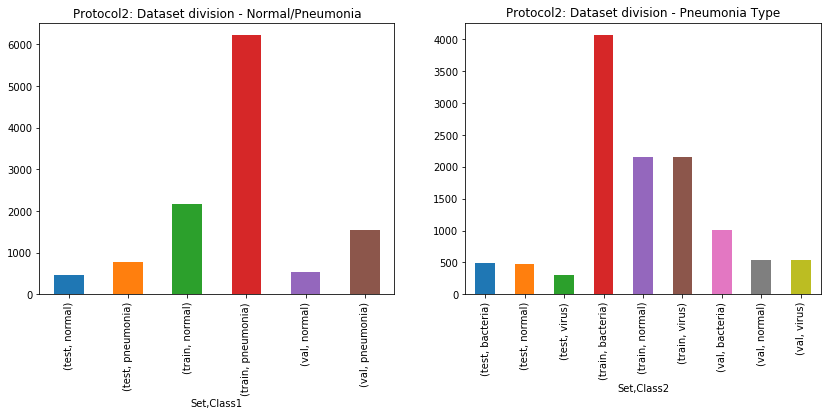

In [7]:
df_protocol2 = load_df('alternative', root_path="./")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.set_title('Protocol2: Dataset division - Normal/Pneumonia')
ax2.set_title('Protocol2: Dataset division - Pneumonia Type')
_ = (df_protocol2.groupby(by=['Set', 'Class1']).size()).plot('bar', ax=ax1)
_ = (df_protocol2.groupby(by=['Set', 'Class2']).size()).plot('bar', ax=ax2)

In [8]:
from collections import defaultdict, Counter

for phase in df_protocol2.Set.unique():
    print('%s distribution: %s' % (phase, str(Counter(df_protocol2[df_protocol2.Set == phase].Class1))))
    print('%s distribution: %s' % (phase, str(Counter(df_protocol2[df_protocol2.Set == phase].Class2))))
    print('\n')

nan distribution: Counter()
nan distribution: Counter()


test distribution: Counter({'pneumonia': 780, 'normal': 468})
test distribution: Counter({'bacteria': 484, 'normal': 468, 'virus': 296})


train distribution: Counter({'pneumonia': 6212, 'normal': 2158})
train distribution: Counter({'bacteria': 4060, 'normal': 2158, 'virus': 2152})


val distribution: Counter({'pneumonia': 1554, 'normal': 540})
val distribution: Counter({'bacteria': 1016, 'normal': 540, 'virus': 538})




### Observamos que os de treinamento dados são altamente desbalanceados, além disso as dimensões das imagens não são sempre iguais.<br>Dessa forma, precisamos ponderar o peso para treinamento.<br><br>Além disso, observamos que o conjunto de validação é razoavelmente pequeno.

### Gera image loaders

In [9]:
img_width, img_height = 226,226

from keras import backend as K

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


In [10]:

#Read our dataset in batches
class DataLoader(Sequence):
    def __init__(self, df = None, batch_size=32, nb_classes=nbClasses, 
                 stratify=None,
                 image_shape=(112, 112), 
                 dataAugmentator=None, 
                 shuffle=True, 
                 normalization_fn=None,
                 load_and_preprocess_fn=None, 
                 path_and_class_translation_fn=None):
        self.df = df
        self.image_shape = image_shape
        self.nb_classes = nb_classes
        self.num_stratums = len(df[stratify].unique())
        self.partial_batch_size = int(batch_size // float(self.num_stratums))
        self.shuffle = shuffle

        self.dataAugmentator = dataAugmentator
        self.normalization_fn = normalization_fn
        self.load_and_preprocess_fn = load_and_preprocess_fn
        self.path_and_class_translation_fn = path_and_class_translation_fn

        indexes = {clazz: df[df[stratify] == clazz].index.tolist() for clazz in df[stratify].unique()}
        max_size = max(map(len, indexes.values()))
        self.size = max_size
        self.indexes = {clazz: np.random.choice(values, size=max_size, replace=True) for clazz, values in indexes.items()}
        
        if shuffle:
            self.indexes = {clazz: np.random.permutation(values) for clazz, values in self.indexes.items()}

    def __len__(self):
        return int(np.ceil(self.size / float(self.partial_batch_size)))

    def __getitem__(self, index):
        # Generate indexes of the batch
        #print(index)
        #print(self.partial_batch_size)
        batch_indexes = []
        
        for key, stratum_indexes in self.indexes.items():
            idx_array = range(index * self.partial_batch_size,
                              min(len(stratum_indexes), (index+1) * self.partial_batch_size))
            #print(idx_array)
            #print(stratum_indexes[idx_array])
            batch_indexes.append(stratum_indexes[idx_array])
            
        batch_indexes = list(chain.from_iterable(batch_indexes))
        #print(batch_indexes)
        np.random.shuffle(batch_indexes)
        batch_shape = tuple([len(batch_indexes)]+list(self.image_shape))
        batch_df = self.df.loc[batch_indexes]
        X = np.zeros(batch_shape, dtype=np.float32)
        Y = []
        
        for i, (index, row) in enumerate(batch_df.iterrows()):
            path, clazz = self.path_and_class_translation_fn(row)
            img = self.load_and_preprocess_fn(path)
            if img is None:
                raise Exception("Unable to load image path: %s" % path)
            if self.dataAugmentator:
                img = self.dataAugmentator(img)            
            if self.normalization_fn:
                img = self.normalization_fn(img)
            X[i, :, :, :] = img
            Y.append(clazz)

        X = np.array(X)
        y = np.vstack(Y)

        return (X, y)

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = {clazz: np.random.permutation(values)
                            for clazz, values in self.indexes.items()}


In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from functools import partial

IMAGE_SIZE = img_width, img_height

# this is the augmentation configuration we will use for training
# For test we don't need to apply transformation
test_datagen = None

def resize_img(img, resize=(112, 112)):
    return cv2.resize(img, resize) 

def img_normalization(img):
    if img is None:
        raise Exception("No input image")
    img = img.astype(np.float32)
    img /= 127.5
    img -= 1.0
    return img

def normalization_fn(img, resize=(112, 112)):
    img = img_normalization(img)
    img = resize_img(img, resize=resize)
    return img

train_generator = DataLoader(df=df_protocol2[df_protocol2.Set == 'train'], 
                             batch_size=32,
                             stratify='Class2', 
                             image_shape=input_shape, 
                             normalization_fn=partial(normalization_fn, resize=IMAGE_SIZE),
                             nb_classes=nbClasses, shuffle=True, 
                             load_and_preprocess_fn=load_and_preprocess_rgb,
                             dataAugmentator=None,
                             path_and_class_translation_fn=partial(path_and_one_hot_class2_translation_fn,
                                                                   nb_classes=nbClasses,
                                                                   base_path=INPUT_DIR) )

val_generator = DataLoader(df=df_protocol2[df_protocol2.Set == 'val'],
                           batch_size=32, stratify='Class2', 
                           image_shape=input_shape, 
                           normalization_fn=partial(normalization_fn, resize=IMAGE_SIZE),
                           nb_classes=nbClasses, shuffle=True, 
                           load_and_preprocess_fn=load_and_preprocess_rgb,
                           dataAugmentator=None,
                           path_and_class_translation_fn=partial(path_and_one_hot_class2_translation_fn,
                                                                 nb_classes=nbClasses,
                                                                 base_path=INPUT_DIR) )

test_generator = DataLoader(df=df_protocol2[df_protocol2.Set == 'test'],
                            batch_size=32, stratify='Class2', 
                            image_shape=input_shape,
                            nb_classes=nbClasses, 
                            normalization_fn=partial(normalization_fn, resize=IMAGE_SIZE),
                            shuffle=True, 
                            load_and_preprocess_fn=load_and_preprocess_rgb,
                            dataAugmentator=None,
                            path_and_class_translation_fn=partial(path_and_one_hot_class2_translation_fn,
                                                                 nb_classes=nbClasses,
                                                                 base_path=INPUT_DIR) )

X, y = train_generator.__getitem__(2)
print(X.shape, y.shape)
f, axes = plt.subplots(4, 3, figsize=(16, 15) )
for idx in range(15):
    img =  X[idx]
    
    axes[idx // 4, idx % 3].imshow(img, interpolation='nearest')
    axes[idx // 4, idx % 3].set_title('class2 = %d' % np.argmax(y[idx]))
    axes[idx // 4, idx % 3].grid('off')
plt.show()


((30, 226, 226, 3), (30, 3))


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# Gera o modelo

In [29]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.applications import xception
from keras.models import Model

base_model = xception.Xception(weights='imagenet', input_shape=input_shape)
print([(i,base_model.layers[i].name) for i in range(len(base_model.layers))])

# freeze layers for training
for i in range(122):
    base_model.layers[i].trainable = False
    
X = base_model.get_layer('avg_pool').output

X = Dense(128)(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)
X = Dense(nbClasses)(X)
X = Activation('softmax', name="prediction")(X)

model = Model(inputs=base_model.input, outputs=X)

[(0, 'input_4'), (1, 'block1_conv1'), (2, 'block1_conv1_bn'), (3, 'block1_conv1_act'), (4, 'block1_conv2'), (5, 'block1_conv2_bn'), (6, 'block1_conv2_act'), (7, 'block2_sepconv1'), (8, 'block2_sepconv1_bn'), (9, 'block2_sepconv2_act'), (10, 'block2_sepconv2'), (11, 'block2_sepconv2_bn'), (12, 'conv2d_13'), (13, 'block2_pool'), (14, 'batch_normalization_13'), (15, 'add_37'), (16, 'block3_sepconv1_act'), (17, 'block3_sepconv1'), (18, 'block3_sepconv1_bn'), (19, 'block3_sepconv2_act'), (20, 'block3_sepconv2'), (21, 'block3_sepconv2_bn'), (22, 'conv2d_14'), (23, 'block3_pool'), (24, 'batch_normalization_14'), (25, 'add_38'), (26, 'block4_sepconv1_act'), (27, 'block4_sepconv1'), (28, 'block4_sepconv1_bn'), (29, 'block4_sepconv2_act'), (30, 'block4_sepconv2'), (31, 'block4_sepconv2_bn'), (32, 'conv2d_15'), (33, 'block4_pool'), (34, 'batch_normalization_15'), (35, 'add_39'), (36, 'block5_sepconv1_act'), (37, 'block5_sepconv1'), (38, 'block5_sepconv1_bn'), (39, 'block5_sepconv2_act'), (40, 'bl

## Treinamento

In [30]:
import keras.optimizers as optimizers

# Compilation
sgd = optimizers.SGD(lr=0.001, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"]) 


## Treinamento

In [14]:
epochs = 50
batch_size = 64

import keras.callbacks
checkpoints = keras.callbacks.ModelCheckpoint("./%s.1_best_val_acc.weights" % MODEL_ID, monitor='val_acc', verbose=1,
                                              save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlyStopcallback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0,
                                                  patience=5, verbose=1, mode='auto')

callbacks = [checkpoints, earlyStopcallback]

#Fit nos dados
history =  model.fit_generator(train_generator, 
                               steps_per_epoch= TRAINING_PERCENTAGE * len(train_generator), 
                               epochs = epochs,
                               validation_data = val_generator,  
                               validation_steps = len(val_generator),
                               callbacks=callbacks)

#model.save_weights('baseline_cnn.h5')

Epoch 1/50
406/406 [==============================] - 408s 1s/step - loss: 1.0591 - acc: 0.4399 - val_loss: 1.0076 - val_acc: 0.5722
Epoch 2/50
406/406 [==============================] - 340s 836ms/step - loss: 0.9392 - acc: 0.5982 - val_loss: 0.8369 - val_acc: 0.6998
Epoch 3/50
406/406 [==============================] - 326s 803ms/step - loss: 0.8328 - acc: 0.6594 - val_loss: 0.7292 - val_acc: 0.7306
Epoch 4/50
406/406 [==============================] - 336s 828ms/step - loss: 0.7438 - acc: 0.6947 - val_loss: 0.6515 - val_acc: 0.7441
Epoch 5/50
406/406 [==============================] - 328s 808ms/step - loss: 0.6873 - acc: 0.7124 - val_loss: 0.6114 - val_acc: 0.7503
Epoch 6/50
406/406 [==============================] - 326s 803ms/step - loss: 0.6402 - acc: 0.7263 - val_loss: 0.5770 - val_acc: 0.7631
Epoch 7/50
406/406 [==============================] - 339s 836ms/step - loss: 0.6106 - acc: 0.7421 - val_loss: 0.5579 - val_acc: 0.7621
Epoch 8/50
406/406 [==============================]

Epoch 28/50
406/406 [==============================] - 343s 846ms/step - loss: 0.3842 - acc: 0.8369 - val_loss: 0.4499 - val_acc: 0.7917
Epoch 29/50
406/406 [==============================] - 344s 848ms/step - loss: 0.3736 - acc: 0.8415 - val_loss: 0.4509 - val_acc: 0.7949
Epoch 30/50
406/406 [==============================] - 338s 832ms/step - loss: 0.3686 - acc: 0.8443 - val_loss: 0.4518 - val_acc: 0.7953
Epoch 31/50
406/406 [==============================] - 342s 843ms/step - loss: 0.3632 - acc: 0.8493 - val_loss: 0.4517 - val_acc: 0.7920
Epoch 32/50
406/406 [==============================] - 344s 847ms/step - loss: 0.3597 - acc: 0.8488 - val_loss: 0.4463 - val_acc: 0.7966
Epoch 33/50
406/406 [==============================] - 339s 836ms/step - loss: 0.3509 - acc: 0.8501 - val_loss: 0.4494 - val_acc: 0.7933
Epoch 34/50
406/406 [==============================] - 341s 840ms/step - loss: 0.3419 - acc: 0.8564 - val_loss: 0.4461 - val_acc: 0.7956
Epoch 35/50
406/406 [====================

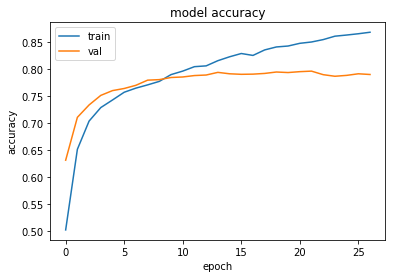

In [31]:
model.load_weights("%s.1_best_val_acc.weights" % MODEL_ID)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [33]:
# evaluate the model
scores = model.evaluate_generator(val_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))




acc: 79.76%


ValueError: need at least one array to concatenate

In [ ]:
# Confusion matrix
#YTrue, YPred = [], []
#for X, Y in val_generator:
#    pred = model.predict(X)
#    YTrue.append(np.argmax(Y, axis=-1))
#    YPred.append(np.argmax(pred, axis=-1))#

#YPred=np.concatenate(np.array(YPred).flatten())
#YTrue=np.concatenate(np.array(YTrue).flatten())

#cm = metrics.confusion_matrix(y_true=YTrue, y_pred=YPred)
#cm = plot_confusion_matrix(cm, range(2), normalize=True,
#                           title='Val - Confusion matrix',
#                           width=4,cmap=plt.cm.Blues)


# Avalia teste

In [35]:
# evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Confusion matrix
#YTrue, YPred = [], []
#for X, Y in test_generator:
#    pred = model.predict(X)
#    YTrue.append(np.argmax(Y, axis=-1))
#    YPred.append(np.argmax(pred, axis=-1))
#
#YPred=np.concatenate(YPred)
#YTrue=np.concatenate(YTrue)

#cm = metrics.confusion_matrix(y_true=YTrue, y_pred=YPred)
#cm = plot_confusion_matrix(cm, range(2), normalize=True,
#                           title='Test - Confusion matrix',
#                           width=4,cmap=plt.cm.Blues)


acc: 76.93%


#### 

In [36]:
model = None
import gc
gc.collect()

6893

## 7.2 Menos camadas congeladas e utilizando regularização

In [37]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.applications import xception
from keras.models import Model

from keras.regularizers import l2

base_model = xception.Xception(weights='imagenet', input_shape=input_shape)
#print([(i,base_model.layers[i].name) for i in range(len(base_model.layers))])

# freeze layers for training
for i in range(105):
    base_model.layers[i].trainable = False
    
X = base_model.get_layer('avg_pool').output

X = Dense(128, kernel_regularizer=l2(0.01))(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)
X = Dense(nbClasses)(X)
X = Activation('softmax', name="prediction")(X)

model = Model(inputs=base_model.input, outputs=X)

In [ ]:
import keras.callbacks
import keras.optimizers as optimizers

checkpoints = keras.callbacks.ModelCheckpoint("./%s.2_best_val_acc.weights" % MODEL_ID, monitor='val_acc', verbose=1,
                                              save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlyStopcallback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0,
                                                  patience=5, verbose=1, mode='auto')

callbacks = [checkpoints, earlyStopcallback]

# Compilation
sgd = optimizers.SGD(lr=0.001, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"]) 



In [ ]:
epochs = 50
batch_size = 64

import keras.callbacks
checkpoints = keras.callbacks.ModelCheckpoint("./%s.2_best_val_acc.weights" % MODEL_ID, monitor='val_acc', verbose=1,
                                              save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlyStopcallback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0,
                                                  patience=5, verbose=1, mode='auto')

callbacks = [checkpoints, earlyStopcallback]

#Fit nos dados
history =  model.fit_generator(train_generator, 
                               steps_per_epoch= TRAINING_PERCENTAGE * len(train_generator), 
                               epochs = epochs,
                               validation_data = val_generator,  
                               validation_steps = len(val_generator),
                               callbacks=callbacks)

#model.save_weights('baseline_cnn.h5')

Epoch 1/50
148/406 [=========>....................] - ETA: 4:13 - loss: 3.5156 - acc: 0.3482

In [ ]:
model.load_weights("%s.2_best_val_acc.weights" % MODEL_ID)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
# evaluate validation set
scores = model.evaluate_generator(val_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Confusion matrix
#YTrue, YPred = [], []
#for X, Y in val_generator:
#    pred = model.predict(X)
#    YTrue.append(np.argmax(Y, axis=-1))
#    YPred.append(np.argmax(pred, axis=-1))#

#YPred=np.concatenate(np.array(YPred).flatten())
#YTrue=np.concatenate(np.array(YTrue).flatten())

#cm = metrics.confusion_matrix(y_true=YTrue, y_pred=YPred)
#cm = plot_confusion_matrix(cm, range(2), normalize=True,
#                           title='Val - Confusion matrix',
#                           width=4,cmap=plt.cm.Blues)


In [ ]:
# evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Confusion matrix
#YTrue, YPred = [], []
#for X, Y in test_generator:
#    pred = model.predict(X)
#    YTrue.append(np.argmax(Y, axis=-1))
#    YPred.append(np.argmax(pred, axis=-1))
#
#YPred=np.concatenate(YPred)
#YTrue=np.concatenate(YTrue)

#cm = metrics.confusion_matrix(y_true=YTrue, y_pred=YPred)
#cm = plot_confusion_matrix(cm, range(2), normalize=True,
#                           title='Test - Confusion matrix',
#                           width=4,cmap=plt.cm.Blues)

# 7.3 Adicionando mais camadas densas para aumentando o grau a complexidade do modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.applications import xception
from keras.models import Model

from keras.regularizers import l2

base_model = xception.Xception(weights='imagenet', input_shape=input_shape)
#print([(i,base_model.layers[i].name) for i in range(len(base_model.layers))])

# freeze layers for training
for i in range(105):
    base_model.layers[i].trainable = False
    
X = base_model.get_layer('avg_pool').output

X = Dense(128, kernel_regularizer=l2(0.01))(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)
X = Dense(128, kernel_regularizer=l2(0.01))(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)

X = Dense(nbClasses)(X)
X = Activation('softmax', name="prediction")(X)

model = Model(inputs=base_model.input, outputs=X)

In [ ]:
epochs = 50
batch_size = 64

import keras.callbacks
checkpoints = keras.callbacks.ModelCheckpoint("./%s.3_best_val_acc.weights" % MODEL_ID, monitor='val_acc', verbose=1,
                                              save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlyStopcallback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0,
                                                  patience=5, verbose=1, mode='auto')

callbacks = [checkpoints, earlyStopcallback]

#Fit nos dados
history =  model.fit_generator(train_generator, 
                               steps_per_epoch= TRAINING_PERCENTAGE * len(train_generator), 
                               epochs = epochs,
                               validation_data = val_generator,  
                               validation_steps = len(val_generator),
                               callbacks=callbacks)

#model.save_weights('baseline_cnn.h5')

In [ ]:
# Load best weights
model.load_weights("%s.3_best_val_acc.weights" % MODEL_ID)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
# evaluate validation set
scores = model.evaluate_generator(val_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


# Confusion matrix
#YTrue, YPred = [], []
#for X, Y in val_generator:
#    pred = model.predict(X)
#    YTrue.append(np.argmax(Y, axis=-1))
#    YPred.append(np.argmax(pred, axis=-1))#

#YPred=np.concatenate(np.array(YPred).flatten())
#YTrue=np.concatenate(np.array(YTrue).flatten())

#cm = metrics.confusion_matrix(y_true=YTrue, y_pred=YPred)
#cm = plot_confusion_matrix(cm, range(2), normalize=True,
#                           title='Val - Confusion matrix',
#                           width=4,cmap=plt.cm.Blues)


In [ ]:
# evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Confusion matrix
#YTrue, YPred = [], []
#for X, Y in test_generator:
#    pred = model.predict(X)
#    YTrue.append(np.argmax(Y, axis=-1))
#    YPred.append(np.argmax(pred, axis=-1))
#
#YPred=np.concatenate(YPred)
#YTrue=np.concatenate(YTrue)

#cm = metrics.confusion_matrix(y_true=YTrue, y_pred=YPred)
#cm = plot_confusion_matrix(cm, range(2), normalize=True,
#                           title='Test - Confusion matrix',
#                           width=4,cmap=plt.cm.Blues)